# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [3]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [4]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.92, '2023-08-18')

(9.52,
 59    2023-11-17
 Name: date, dtype: object)

9 0.02 0.22
Bull
0.22


### regression_line(X, Y)
regression_ratio(df, window=10):

11.01 -0.04
Above
-0.04


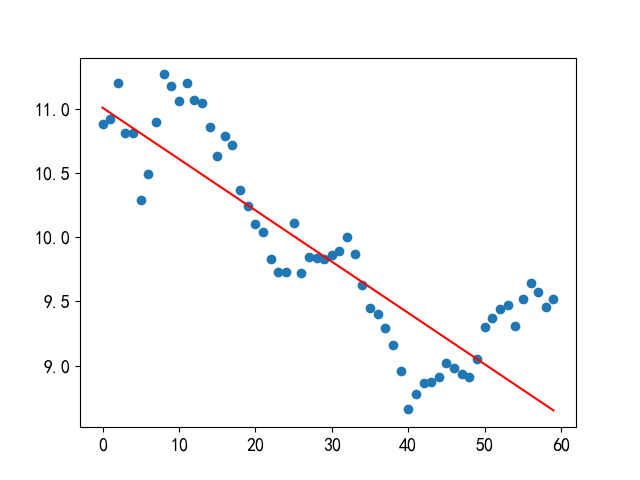

In [5]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

11.01 -0.04
Above
-0.04


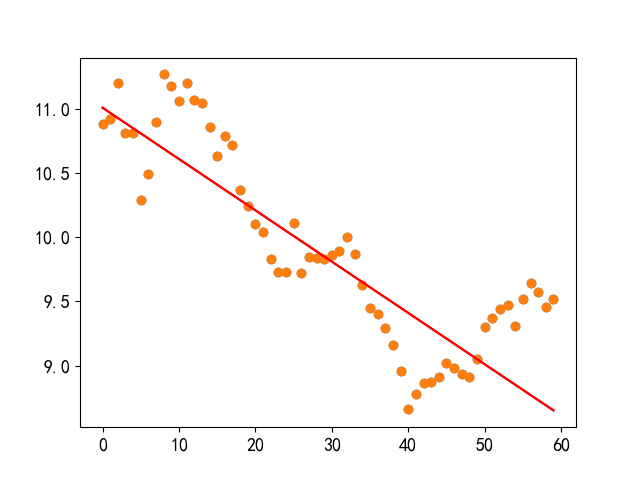

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [7]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'max5', 'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean',
       'hv', 'lv'],
      dtype='object', length=175)

### check_postion_vol_price

In [8]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high   low  close         vol       amount  \
59  2023-11-17  601360  9.46  9.56  9.43   9.52  47530625.0  450892698.0   

    ma5d  ma10d  ...   hmax  high4  low4  lastdu4  lmin  min5  cmean  \
59  9.54   9.46  ...  10.16   9.77  9.36     1.04  8.58   9.3    9.4   

             hv          lv  Positon  
59  179302230.0  48504318.0  Neutral  

[1 rows x 176 columns]

In [9]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'hmax', 'high4', 'low4', 'lastdu4', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=176)

0    2023-08-18
1    2023-08-21
2    2023-08-22
Name: date, dtype: object

59   2023-11-17
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

lastb:0.0 xratio:-0.04 


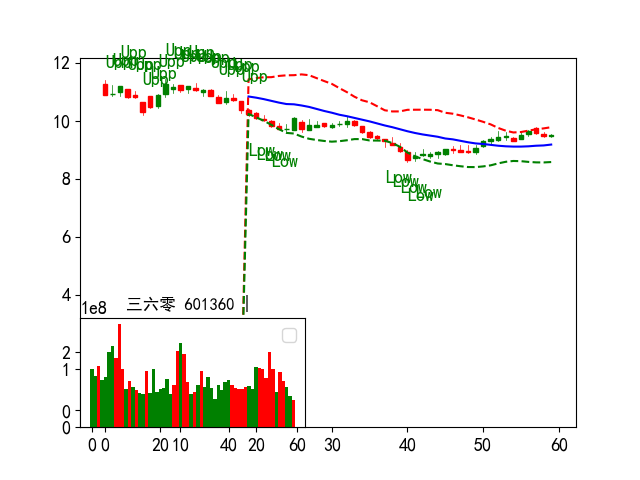

In [10]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'b', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [11]:
'code' in dfc.columns

True

### show_channel_mpl

In [12]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [13]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [14]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'w'

In [15]:
resample = 'W-FRI'
# resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

lastb:0.0 all code: 4961
1.95 (4961,) 301283 (292, 6)
resample:W-FRI
use time:16.61


In [16]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high    low  close         vol        amount
date                                                           
2023-11-17  11.73  11.8  11.56  11.62  63911811.0  7.433935e+08

### Test InStock

In [17]:
df.loc['301083']

open   high    low  close        vol       amount
date                                                          
2022-08-19  15.16  15.16  14.31  14.38  3979561.0   58478828.0
2022-08-26  13.24  13.44  13.07  13.25  1382760.0   18351198.0
2022-09-02  12.90  13.14  12.86  13.12   853122.0   11166912.0
2022-09-09  12.87  12.95  12.66  12.76   897539.0   11483120.0
2022-09-16  12.42  12.46  11.97  12.03   815200.0    9932161.0
...           ...    ...    ...    ...        ...          ...
2023-10-20  16.11  16.50  15.81  15.82  1942200.0   31157364.0
2023-10-27  16.23  16.65  16.00  16.30  2348800.0   38021572.0
2023-11-03  15.98  17.95  15.85  17.02  9484947.0  160420160.0
2023-11-10  17.22  17.56  17.03  17.35  3849317.0   66782020.0
2023-11-17  17.35  17.75  17.32  17.73  3181700.0   55900267.0

[63 rows x 6 columns]

## ra_diff

In [18]:
df = df.groupby(level=[0]).tail(30).groupby(level=[0]).apply(ra_diff)


In [19]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(30, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [20]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [21]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [22]:
# df.loc['000002'][-10:]

## sina_dm

In [23]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

lastb:0.0 

('2023-11-16',
 code
 301072    中捷精工
 Name: name, dtype: object)

In [24]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2023-11/17/23 17:45:03'

code
002651   2023-11-17 15:00:00
002675   2023-11-17 15:00:00
Name: ticktime, dtype: datetime64[ns]

165.06615899801255

### Combine ratio and idx

if 'date' in df.columns:
    print('error duplicated date col')
    if isinstance(df,pd.MultiIndex):
        df.drop('date', axis=1, inplace=True)
else:
    df = df.reset_index().set_index('code')
    df['idx'] = df_idx_detect
    df['xratio'] = df_reg_ratio
    df['name'] = sina_dm.name
    df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [25]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [26]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
# h5.loc[code_muti][:2]

freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf['amount']=mdf['volume'].apply(lambda x: round(x /100,2)) 
mdf['vol']=(mdf.volume / mdf.close).map(lambda x: round(x/100, 2))
mdf['volume'] = mdf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')

['/all_10']
G:\sina_MultiIndex_data.h5


(4094364, 6)

1.0

31839.860436151

In [27]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2023-11-17'

In [28]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2023-11-18 00:00:00
close                 11.621539
volume                     0.09
amount             294097556.75
vol                 25306247.89
Name: 000002, dtype: object

###  实时成交量个股Top

In [29]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [30]:
nowdf.shape,top20_nd

((4900, 5),
         volume  name
 code                
 002400    0.94  省广集团
 601901    0.88  方正证券
 002239    0.79   奥特佳
 000564    0.63  ST大集
 300242    0.56  佳云科技
 600733    0.52  北汽蓝谷
 000056    0.51  皇庭国际
 002195    0.50  岩山科技
 600839    0.47  四川长虹
 300180    0.46  华峰超纤
 000572    0.41  海马汽车
 002426    0.41  胜利精密
 002178    0.40  延华智能
 300063    0.40  天龙集团
 600775    0.39  南京熊猫
 002291    0.39  遥望科技
 300375    0.37  鹏翎股份
 601099    0.37   太平洋
 002131    0.37  利欧股份
 601728    0.36  中国电信)

### 合并实时成交量及SinaDM

In [31]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name   open  llastp    now  trade   high    low    buy   sell  \
code                                                                    
301072  中捷精工  27.94   28.24  28.62    0.0  28.85  27.92  28.62  28.63   

         volume  ...  a5_v     a5          dt            ticktime  b1_vv  \
code             ...                                                       
301072  4463731  ...  2000  28.67  2023-11-17 2023-11-17 15:35:30   2776   

        close     nvol         timel        vol       amount  
code                                                          
301072  28.62  4463731  1.700207e+09  666859.63  19049337.76  

[1 rows x 39 columns]

## check HDF LastDate

In [32]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4899, 7)

(62, 7)

In [33]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open   high    low  close        vol       amount  ra_diff
code   date                                                                  
689009 2023-11-10  34.5  34.85  33.86  34.45  3750355.0  128768664.0     1.12

In [34]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [35]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [36]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [37]:
dfs=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [38]:
# dfs.loc['000002'][-5:].upper
dfs.loc['603357'][-5:][['close','upper','low','boll']]
dftemp = dfs.loc['603357']
dftemp[dftemp.close > dftemp.upper]

close  upper   low   boll
date                                 
2023-10-20   8.57  11.46  8.55  10.01
2023-10-27   8.65  11.41  8.54   9.90
2023-11-03   8.63  11.18  8.55   9.76
2023-11-10   9.22  11.05  9.12   9.69
2023-11-17   9.24  10.89  9.14   9.61

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma5, ma10, ma20, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 27 columns]

In [39]:
# dfs.loc['688027']
dfs['ma51d'] = round(dfs['close'].rolling(5).mean(), 2)
show_tdx_data(dfs.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 28


ra_diff     hat    close  volsum5d     hmax     lmin  perc1d  \
date                                                                       
2023-11-10     1.08  284.44  1775.84      21.3  1906.52  1616.25   -1.95   
2023-11-17     1.07  277.83  1753.42      31.3  1906.52  1616.25   -1.26   

               ma20  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  \
date                                                                     
2023-11-10  1781.31 -45.43 -11.93 -24.49  81.30  21.86    7.95   -1.26   
2023-11-17  1783.48  31.87 -45.43 -11.93 -24.49  81.30    4.58    0.14   

              ma51d  ra_diff  
date                          
2023-11-10  1731.96     1.08  
2023-11-17  1732.44     1.07

### Append Now SinaTo MultiIndex dfNow

In [40]:
cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    sina_today=sina_dm.copy()
    if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
        sina_today['date']=pd.to_datetime(cct.get_today())
        print('concat1 init:sina_today:%s'%(sina_today.index[0]))
        # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
        # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
        # sina_today['idx'] = df_idx_detect2
        # sina_today['xratio'] = df_reg_ratio2
        # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
        if 'vol' in sina_today.columns:
            sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
        else:
            sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

    if sina_today.index[0] not in df.index:
        # df.index=df.index.append(sina_dm.index)
        print('concat1:sina_today:%s %s'%(sina_today.index[0]))
        df = pd.concat([df, sina_today])


#         sina_today=sina_dm.copy()
#         #drop line and append idx
#         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
#             sina_today['date']=pd.to_datetime(cct.get_today())
#             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

#             sina_today['idx'] = df_idx_detect2
#             sina_today['xratio'] = df_reg_ratio2
#             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
#             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


#         df = get_multiIndex_drop_last_row(df,dropline=1)

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat2:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])
        df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfNow=get_Append_Sina_To_MultiTDX(dfs.groupby(level=[0]).tail(30),sinadm)
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfs.groupby(level=[0]).tail(30).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df.loc[code_df][-2:]


'2023-11-17'

In [41]:
# dfNow.loc['000002']

### Xratio and tail 30 MultiIndex 

In [42]:
# dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
df_xratio.index =df_xratio.to_frame().index.droplevel(1)
dfNow['xratio'] = df_xratio

In [43]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2023-11-10    6.88
2023-11-17    6.56
Name: upper, dtype: float64

lastb:0.0 xratio:-0.11 ra_diff:1.15


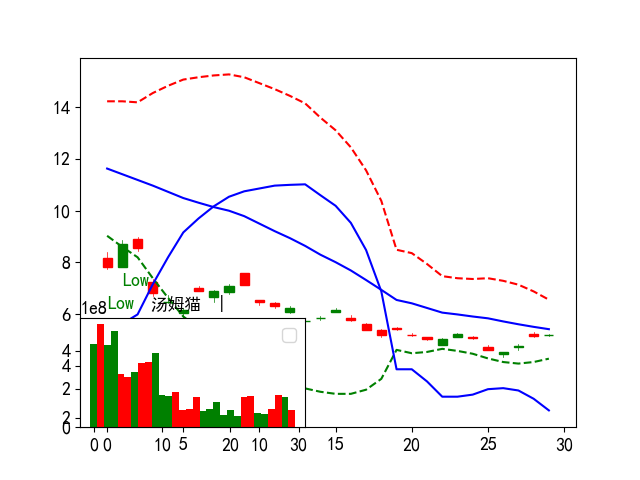

In [44]:
dfNow.loc['300459'][-2:].upper
show_ohlc_upper(dfNow.loc['300459'][-30:],code='300459')

002400 1.41
lastb:0.0 xratio:0.0 ra_diff:1.41


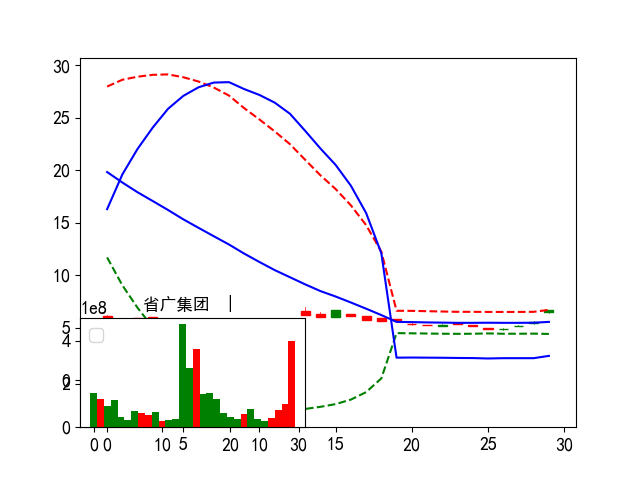

601901 1.54
lastb:0.0 xratio:0.06 ra_diff:1.54


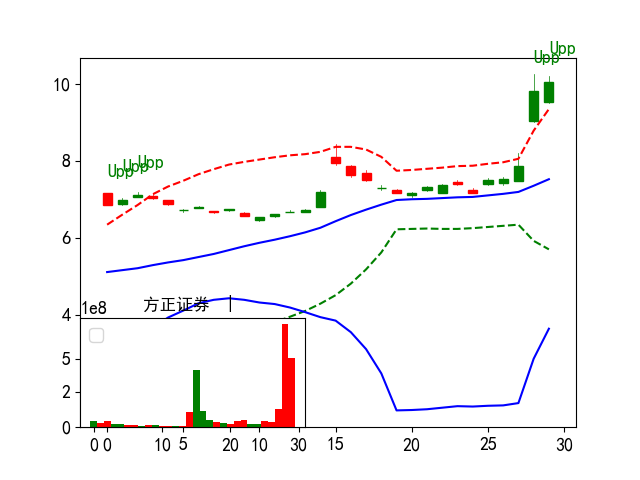

002239 1.4
lastb:0.0 xratio:0.01 ra_diff:1.4


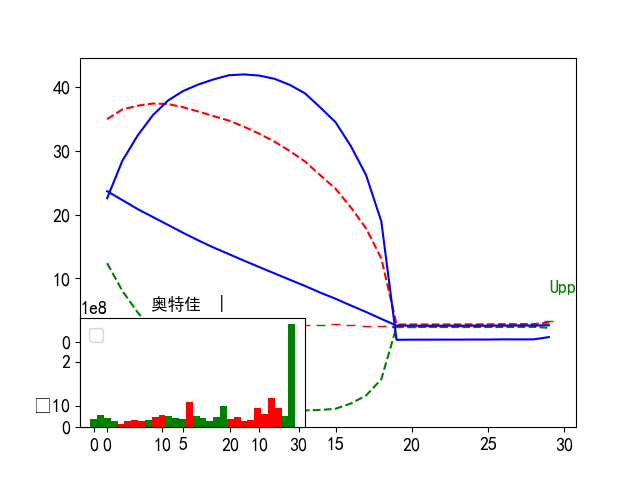

000564 1.28
lastb:0.0 xratio:-0.0 ra_diff:1.28


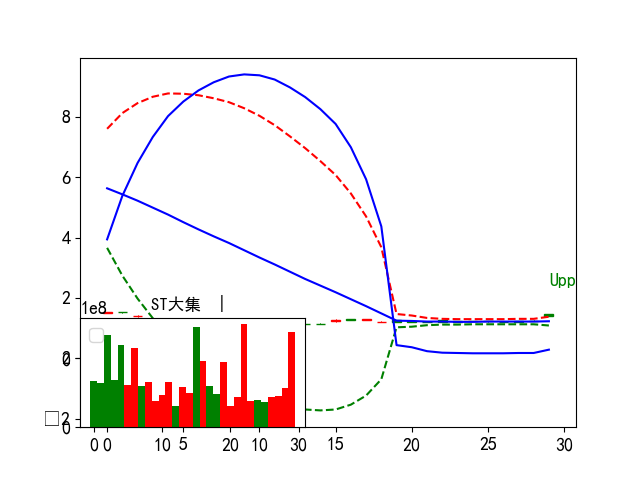

300242 1.66
lastb:0.0 xratio:-0.01 ra_diff:1.66


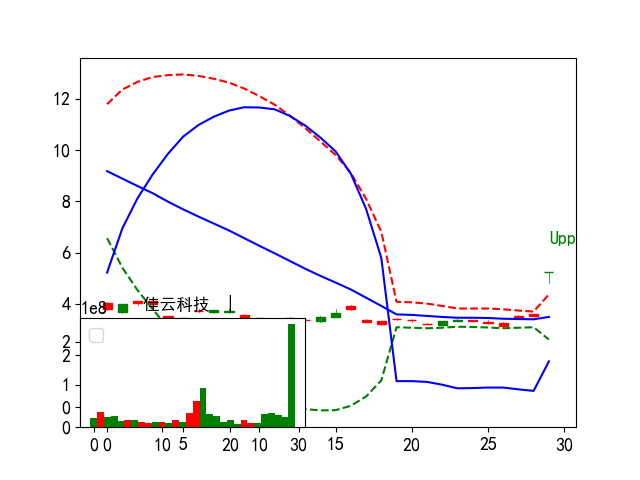

600733 1.41
lastb:0.0 xratio:0.04 ra_diff:1.41


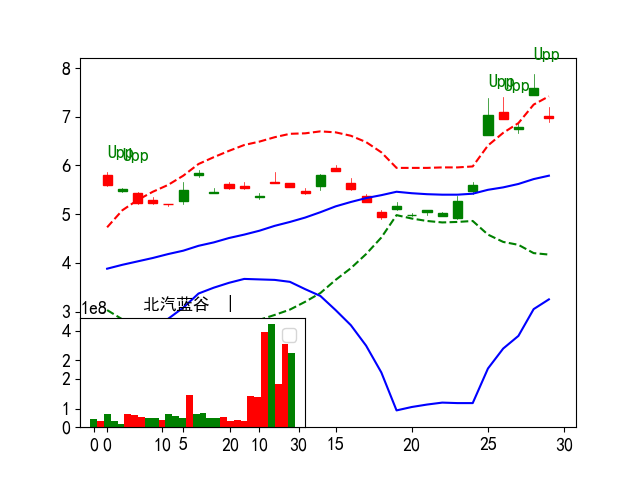

000056 1.77
lastb:0.0 xratio:-0.02 ra_diff:1.77


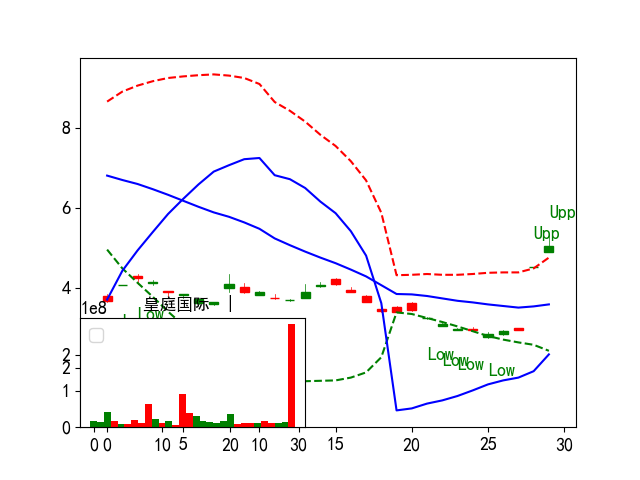

002195 1.14
lastb:0.0 xratio:-0.0 ra_diff:1.14


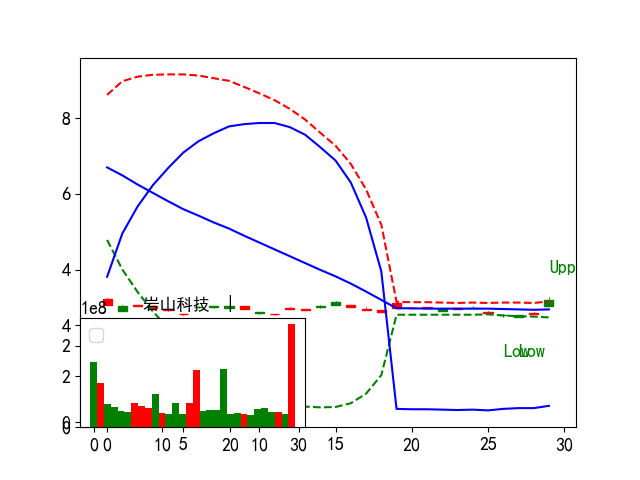

600839 1.68
lastb:0.0 xratio:0.05 ra_diff:1.68


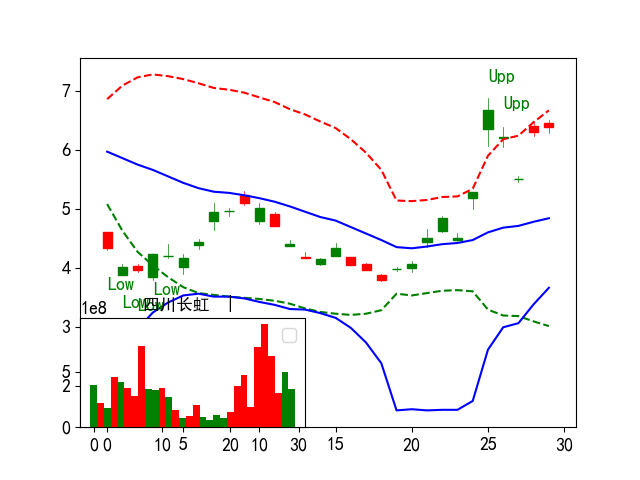

300180 1.59
lastb:0.0 xratio:0.03 ra_diff:1.59


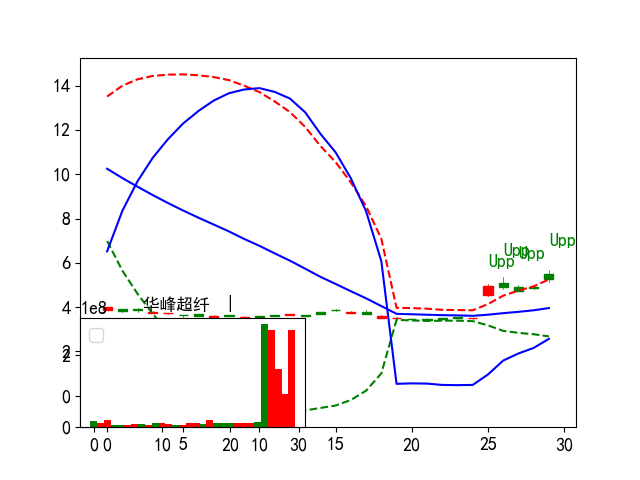

In [45]:
for co in top20_nd.index[:10]:
    print(co,dfNow.loc[co].ra_diff[-1])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfNow.loc[co][-30:],co)

In [46]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date  open   high    low  close         vol       amount  \
code                                                                    
688981 2023-11-17  54.0  54.07  53.38  53.70  15310541.0  821891004.0   
688800 2023-11-17  47.0  48.20  45.95  46.42   2997262.0  140276552.0   

        ra_diff    ma5   ma10  ...  perc5d   vol1d  vol2d  vol3d   vol4d  \
code                           ...                                         
688981     1.14  56.01  54.11  ...   -1.58  -69.21  79.76 -41.35  -33.33   
688800     1.21  41.09  40.68  ...    7.01  191.13 -29.05 -69.75  345.87   

        vol5d  volsum5d  ma51d  xratio   idx  
code                                          
688981  41.43     -22.7  56.01    0.18  1.20  
688800 -47.50     390.7  41.09   -0.85  5.92  

[2 rows x 31 columns]

In [47]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [48]:
df.loc['000002'][-2:]

open   high    low  close         vol        amount  ra_diff
date                                                                     
2023-11-10  11.91  11.94  11.74  11.89  70679592.0  8.353187e+08     1.06
2023-11-17  11.73  11.80  11.56  11.62  63911811.0  7.433935e+08     1.03

In [49]:
dfNow.loc['000002'][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2023-11-10  11.91  11.94  11.74  11.89  70679592.0  8.353187e+08     1.06   
2023-11-17  11.73  11.80  11.56  11.62  63911811.0  7.433935e+08     1.03   

              ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                             ...                                       
2023-11-10  11.81  12.69  13.16  ...    -9.1 -14.84  20.00 -17.43  79.14   
2023-11-17  11.61  12.45  13.08  ...    -7.7  -9.58 -14.84  20.00 -17.43   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2023-11-10  55.60     122.5  11.81   -0.08 -2.16  
2023-11-17  79.14      57.3  11.61   -0.09 -2.29  

[2 rows x 30 columns]

# 基础处理

In [50]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2023-10-23 2023-11-17


open   high    low  close          vol        amount  \
code   date                                                                
000001 2023-11-10  10.45  10.47  10.29  10.30  104504416.0  1.080650e+09   
       2023-11-17  10.22  10.25  10.12  10.15   90336217.0  9.176167e+08   

                   ra_diff    ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2023-11-10     1.01  10.57  10.91  11.24  ...   -8.04  48.14 -23.30   
       2023-11-17     1.00  10.40  10.79  11.18  ...   -7.73 -13.56  48.14   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2023-11-10  74.82 -23.13  31.46     108.0  10.57   -0.05 -1.02  
       2023-11-17 -23.30  74.82 -23.13      63.0  10.40   -0.06 -1.12  

[2 rows x 30 columns]

Low:2023-10-23


Timestamp('2023-10-27 00:00:00')

In [51]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(443, 30)
count dd.couts
(code    date      
688260  2023-10-27    4
603985  2023-10-27    4
603629  2023-10-27    4
603353  2023-10-27    4
603266  2023-10-27    4
Name: couts, dtype: int64, (443, 31))
dt_low:2023-10-23 df:155 Index(['688260', '603985', '603629', '603353', '603266'], dtype='object', name='code') df_idx:1767
Main Down dd :0 MainUP df:155 couts std:1.1 
time: 0.01  83
lastb:0.0 

In [52]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2023-11-17  19.48  20.48  19.43  20.21  12976903.0  2.599109e+08     1.13   

              ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                             ...                                       
2023-11-17  18.72  18.93  19.86  ...    6.54  271.8 -34.25   0.41 -12.25   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2023-11-17  49.22     274.9  18.72    -0.2 -0.17  

[1 rows x 30 columns]

## 最近30天筛选

In [53]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(30)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [54]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(8306, 30)
count dd.couts
(code    date      
301209  2023-04-21    13
Name: couts, dtype: int64, (8306, 31))
(code    date      
002318  2023-11-10    13
603696  2023-11-17    13
Name: couts, dtype: int64, (2927, 31))
Count:2927 31


couts  ra_diff  xratio  idx   hat  close  volsum5d  hmax  \
code   date                                                                   
600432 2017-04-21      3     6.52     0.0  0.0  2.09   6.98     163.6  7.38   
600260 2022-10-21      2     2.97     0.0  0.0  0.79   2.88      91.6  3.27   
600069 2019-11-15      1     2.79     0.0  0.0  0.69   2.85     362.8  3.43   

                   lmin  perc1d  ma20  vol1d   vol2d   vol3d  vol4d   vol5d  \
code   date                                                                   
600432 2017-04-21  5.67   -2.38  6.57 -24.81  171.16  104.90 -35.72  -51.96   
600260 2022-10-21  2.35    2.86  2.75  67.52   39.87  -46.78 -21.76   52.71   
600069 2019-11-15  2.52    1.06  2.84  34.62   25.54  -26.13  -0.91  329.63   

                   perc3d  perc5d  
code   date                        
600432 2017-04-21    6.56   -3.19  
600260 2022-10-21   10.34   16.60  
600069 2019-11-15    1.42    9.62

#### filter today

In [55]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [56]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [57]:
dfs.loc['301073'][-5:].ra_diff

date
2023-10-20    1.00
2023-10-27    1.06
2023-11-03    1.02
2023-11-10    1.02
2023-11-17    1.05
Name: ra_diff, dtype: float64

lastb:0.0 xratio:-0.08 ra_diff:1.03


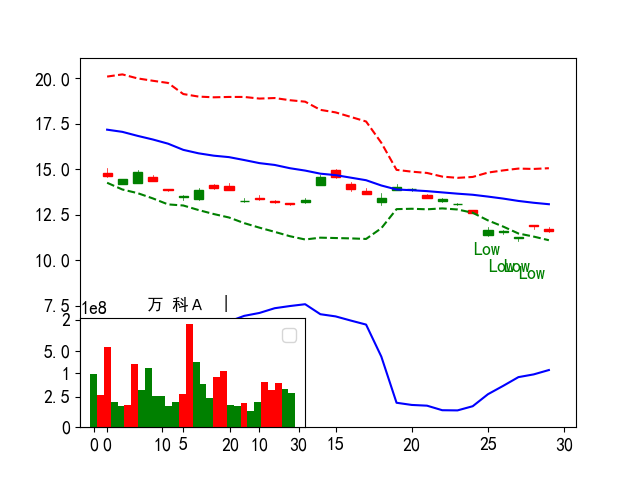

In [58]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfs.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 最近15天数据

In [59]:
dfs_tail9 = dfs.groupby(level=[0]).tail(15)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [60]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2023-11-03    1.02
        2023-11-10    1.02
        2023-11-17    1.02
399001  2023-11-03    1.03
        2023-11-10    1.04
        2023-11-17    1.04
399006  2023-11-03    1.04
        2023-11-10    1.06
        2023-11-17    1.05
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [61]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:15 30


ra_diff  xratio   idx   hat  close  volsum5d   hmax   lmin  \
date                                                                     
2023-11-10     1.43    0.21  2.27  7.40  16.35     733.9  19.77  11.81   
2023-11-17     1.47    0.23  2.62  7.61  16.88     -69.0  19.77  11.81   

            perc1d   ma20  vol1d  vol2d  vol3d  vol4d   vol5d  perc3d  perc5d  
date                                                                           
2023-11-10    2.44  14.04 -38.59 -44.26  42.67 -17.32  791.37  -10.80   20.31  
2023-11-17    3.24  14.27 -11.52 -38.59 -44.26  42.67  -17.32   -5.54    8.14

## Run-Filter强势Upper

### filterRule test

In [62]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



9 -0.09 -0.85


'Bear'

-0.85

date
2023-10-20   -0.00
2023-10-27   -0.00
2023-11-03   -0.00
2023-11-10   -0.01
2023-11-17   -0.02
Name: xratio, dtype: float64

lastb:0.0 xratio:-0.02 ra_diff:1.0


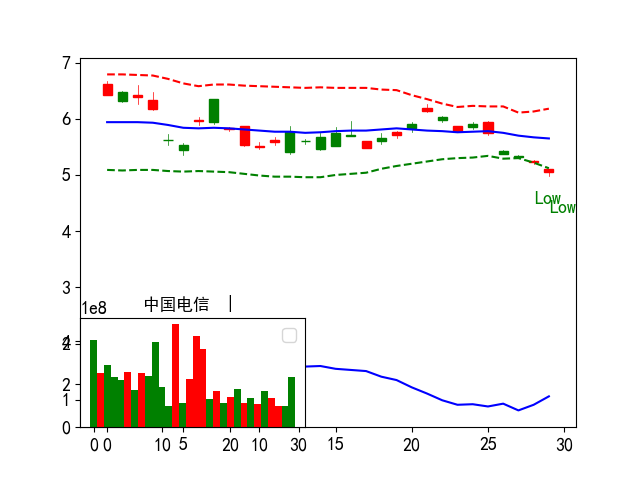

In [63]:
code_filter = '601728'


# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfs.loc[code_filter][-60:], code=code_filter)



In [64]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

lastb:0.0 xratio:-0.02 ra_diff:1.21


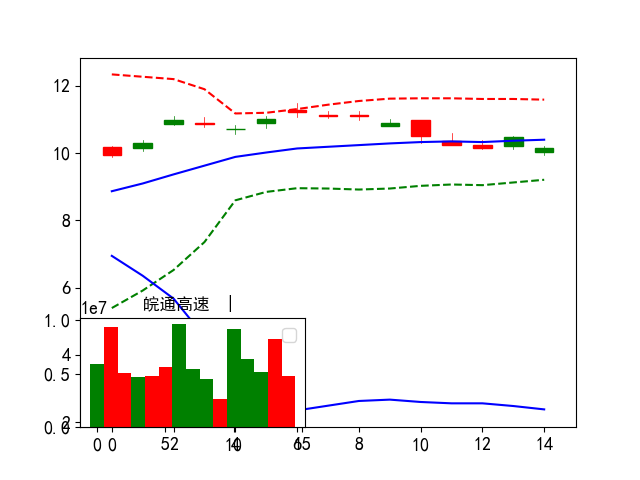

In [65]:
code='600012'
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfs_tail9.loc[code],code=code)

In [66]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 603949    11
 Name: couts, dtype: int64,
 (2562, 39))

Count:2562 39


name  couts       date  perc  ra_diff  xratio    idx    hat  close  \
code                                                                         
603949  雪龙集团     11 2023-11-17 -0.81     1.87    0.60   5.46  16.92  27.05   
603602  纵横通信     11 2023-11-17  0.80     1.37    0.15   3.02   5.53  16.37   
603220  中贝通信     11 2023-11-17 -1.87     3.40    1.37  19.14  41.20  46.19   
002569  ST步森     10 2023-11-17  5.04     1.74    0.13   2.41   4.04   8.54   
300555  ST路通     10 2023-11-17  5.58     1.40    0.07   1.84   2.40   8.70   
300210  森远股份     10 2023-11-17  7.42     3.23    0.17   5.49   6.96   8.98   
300625  三雄极光     10 2023-11-17  6.14     1.34    0.07   2.19   3.37  15.04   
600594  益佰制药     10 2023-11-17  2.78     1.15    0.02   0.54   0.93   5.92   
300298  三诺生物     10 2023-11-17 -0.10     1.25    0.03   5.55   8.11  28.71   
600025  华能水电     10 2023-11-17 -0.62     1.19    0.04   0.75   1.26   8.05   

        volsum5d  ...  perc1d   ma20   llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                         
603949     150.9  ...   -1.21  20.72  26.82  -29.15  136.15  -69.88  126.74   
603602      92.1  ...    4.00  13.32  16.11  -19.78    2.70   -3.42   33.95   
603220      -1.4  ...   11.57  26.45  45.70   -4.99   32.38  -28.62   28.72   
002569     865.2  ...   14.78   6.41   8.25  200.09    9.50  -33.02  757.16   
300555     694.1  ...    7.67   6.91   8.18  108.54  -52.99  658.96   -3.41   
300210     527.0  ...   14.39   4.16   8.21  -18.61  -23.94   74.88  102.38   
300625     356.9  ...    7.81  12.83  14.04  388.03  -52.47    7.83    4.88   
600594     348.1  ...    1.54   5.50   5.73   42.57   19.23  -74.73  385.69   
300298     109.5  ...    0.17  25.38  28.30   28.26  -64.04  -32.58  163.43   
600025     100.4  ...    1.51   7.35   8.00   10.17   -8.53   14.10  -12.07   

         vol5d  perc3d  perc5d  
code                            
603949  -12.95   -0.07   16.54  
603602   78.69    9.43   16.85  
603220  -28.89    4.74   32.35  
002569  -68.50    7.83   12.22  
300555  -17.03   23.58   21.68  
300210  392.28   88.26  149.44  
300625    8.64   10.91   14.37  
600594  -24.69    6.86    1.02  
300298   14.41   -1.00   10.89  
600025   96.72    6.91    6.91  

[10 rows x 22 columns]

#### hmax Top upper > 1

In [67]:
# dfs_tail9.loc['600103']

In [68]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
000628    6
Name: couts, dtype: int64 (344, 39)


(code
 000628    6
 Name: couts, dtype: int64,
 (344, 39))

Count:226 39


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
000628  高新发展      6 2023-11-17   0.88     4.17    1.20  41.69  56.04  57.10   
603991  至正股份      3 2023-11-17   4.23     1.70    0.18  20.97  19.87  56.12   
300180  华峰超纤      2 2023-11-17   6.59     1.59    0.05   2.05   2.57   5.50   
000056  皇庭国际      2 2023-11-17  -7.01     1.77   -0.02   1.61   2.33   5.04   
002729  好利科技      2 2023-11-17  -1.81     1.42    0.01   5.39   6.90  23.90   
002657  中科金财      3 2023-11-17  -4.29     1.51    0.08   6.49   8.17  21.89   
300554  三超新材      2 2023-11-17   0.71     2.06    0.23  16.78  20.08  35.61   
002238  天威视讯      3 2023-11-17   2.12     2.05    0.09   5.94   7.42  12.53   
603528  多伦科技      2 2023-11-17  10.02     2.03    0.07   6.35   5.87  13.94   
300290  荣科科技      3 2023-11-17   2.33     1.81    0.08   3.10   4.12   7.91   

        volsum5d  ...  perc1d   ma20   llow    vol1d    vol2d    vol3d  \
code              ...                                                    
000628    6653.6  ...    0.37  22.19  54.90   -31.51   -20.26  6589.00   
603991    2204.9  ...   22.94  37.75  54.00   186.02  2116.61   -46.84   
300180    2094.4  ...   11.56   3.96   5.12   195.91   -43.60   -39.84   
000056    1940.3  ...   11.50   3.58   4.88  1903.87    14.45     4.82   
002729    1785.0  ...    9.94  19.68  22.63   314.53   -27.85   -13.98   
002657    1374.3  ...    4.74  16.54  21.67    -2.33   155.01   -60.32   
300554    1274.0  ...    3.67  20.68  33.33   -43.03  1047.40   -44.07   
002238    1135.1  ...   -2.26   7.36  12.40    65.14    18.86   998.76   
603528    1097.4  ...   61.16   8.10  11.40   820.23   -58.32    19.06   
300290    1055.9  ...   15.98   5.24   7.85   111.57    -8.68   -62.35   

         vol4d    vol5d  perc3d  perc5d  
code                                     
000628  213.64   -97.30   79.45  249.66  
603991  -10.98   -39.89   57.29   54.56  
300180   -6.05  1987.98    8.48   57.59  
000056  -32.83    50.02   73.20   70.85  
002729  -56.54  1568.86   15.46   33.67  
002657   42.00  1239.94   14.19   49.73  
300554    8.57   305.10   79.67   95.12  
002238   10.41    41.91  101.77   91.88  
603528  131.78   184.61   66.15   80.10  
300290  -12.80  1028.12    9.41   60.77  

[10 rows x 22 columns]

In [69]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [70]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:344 39


name  couts       date   perc  ra_diff  ra_diff  xratio    idx    hat  \
code                                                                            
000628  高新发展      6 2023-11-17   0.88     4.17     4.17    1.20  41.69  56.04   
603496  恒为科技      4 2023-11-17   5.10     3.64     3.64    0.94  26.09  32.21   
300765   新诺威      8 2023-11-17   6.72     3.45     3.45    0.86  24.36  31.47   
603220  中贝通信      8 2023-11-17  -1.87     3.40     3.40    1.37  19.14  41.20   
300210  森远股份      6 2023-11-17   7.42     3.23     3.23    0.17   5.49   6.96   
600520  文一科技      5 2023-11-17   6.11     3.04     3.04    0.56  24.32  27.69   
603629  利通电子      2 2023-11-17   1.19     2.92     2.92    0.44  11.93  20.55   
002786  银宝山新      4 2023-11-17   9.99     2.49     2.49    0.13   7.20   6.65   
002771   真视通      4 2023-11-17  -1.33     2.36     2.36    0.49  10.37  20.97   
300097  智云股份      3 2023-11-17  -2.18     2.35     2.35    0.23   2.89   7.48   
603283  赛腾股份      4 2023-11-17  10.00     2.33     2.33    0.84  36.40  41.46   
002584  西陇科学      1 2023-11-17  10.03     2.33     2.33    0.11   5.33   5.84   
002992  宝明科技      2 2023-11-17  10.01     2.32     2.32    0.32  13.34  18.27   
300814  中富电路      3 2023-11-17  19.99     2.31     2.31    0.54   3.66  19.27   
603037  凯众股份      4 2023-11-17   4.98     2.30     2.30    0.37  12.57  13.51   
300364  中文在线      3 2023-11-17   2.54     2.29     2.29   -0.11  14.57  16.05   
603985  恒润股份      2 2023-11-17  -4.93     2.27     2.27    0.98  18.33  32.56   
301236  软通动力      3 2023-11-17  -3.12     2.26     2.26    0.35  17.86  23.97   
300580   贝斯特      3 2023-11-17  -0.15     2.26     2.26    0.32   9.62  13.70   
300475  香农芯创      1 2023-11-17   4.70     2.07     2.07    0.11   8.58  20.66   

        close  ...  perc1d   ma20   llow   vol1d   vol2d    vol3d   vol4d  \
code           ...                                                          
000628  57.10  ...    0.37  22.19  54.90  -31.51  -20.26  6589.00  213.64   
603496  44.96  ...   46.16  24.17  41.10   32.01  124.01   -54.32    9.29   
300765  37.97  ...   18.10  18.49  34.66   53.38  -22.98   -51.40   37.24   
603220  46.19  ...   11.57  26.45  45.70   -4.99   32.38   -28.62   28.72   
300210   8.98  ...   14.39   4.16   8.21  -18.61  -23.94    74.88  102.38   
600520  37.88  ...   11.38  17.43  36.33  -15.03   22.29   -11.51  109.72   
603629  36.56  ...    3.25  25.38  34.35   35.60   -8.83   -18.45  117.88   
002786  13.43  ...   61.03   6.94  12.23   32.68  -31.86    80.15  -15.09   
002771  28.20  ...   14.31  18.75  27.71  148.05   17.03    12.32  -67.05   
300097  12.09  ...   13.84   8.50  11.70  184.23    1.38   -50.46   59.55   
603283  79.30  ...   24.00  45.76  71.22   63.87  152.09    63.26   69.33   
002584  11.85  ...   48.12   6.19  11.27  -24.84  685.19   -38.55  371.76   
002992  78.27  ...   23.53  64.28  70.10  278.40   17.82    -3.90  -23.59   
300814  40.88  ...   22.98  31.44  33.47  177.32  -23.00    24.63  -10.72   
603037  27.60  ...   26.78  16.73  25.10   54.98   33.89   107.46  -26.39   
300364  28.25  ...   11.22  16.12  27.06  -32.36   48.98   404.79   18.56   
603985  43.54  ...    1.00  28.83  41.82    4.24  -16.80   -28.76   40.29   
301236  44.36  ...   18.01  27.82  43.52  -31.31   84.45   -25.71   67.16   
300580  34.20  ...    3.95  24.53  33.00  -39.06   18.83    78.32   54.71   
300475  41.90  ...   24.96  32.78  39.11   29.20  108.17     8.88  102.53   

         vol5d  perc3d  perc5d  
code                            
000628  -97.30   79.45  249.66  
603496  -24.92   41.92   15.55  
300765  -18.96   37.92   61.92  
603220  -28.89    4.74   32.35  
300210  392.28   88.26  149.44  
600520  203.78   88.46  167.33  
603629  -13.64    8.94   33.28  
002786  -18.55   86.53   92.41  
002771  186.72  -12.59   85.53  
300097  -70.29   16.14    2.46  
603283   -1.90   72.39   73.52  
002584  -37.28  100.17  107.53  
002992  -46.82   24.40   17.15  
300814  -36.87   33.81   13.05  
60

lastb:0.0 xratio:-0.01 ra_diff:1.28


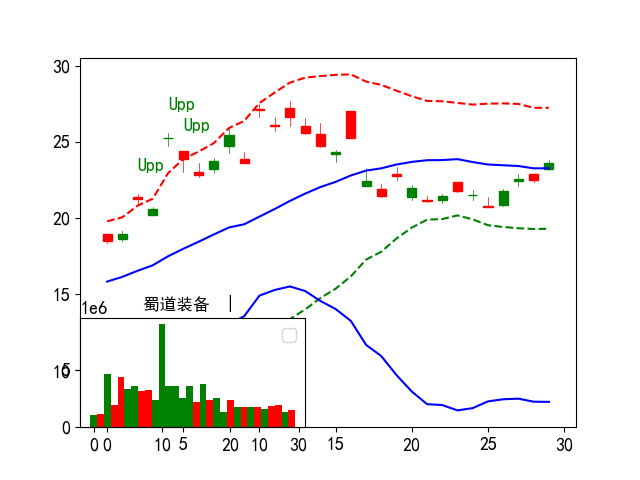

In [71]:
show_ohlc_upper(dfs.loc['300540'][-60:],code='300540')

### df_mask250 upper xratio

In [72]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1])
# show_tdx_data(df_mask250.loc[code_t])

(1470, 30)

count dd.couts
(code    date      
300765  2023-10-13    6
        2023-10-20    6
        2023-10-27    6
Name: couts, dtype: int64, (591, 31))
compute percent
df_mask250:361 df_mask_hmax:344
cross_hamx:155
Count:104 39


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                           
601127    赛力斯      2 2023-10-20   1.00     3.19    1.55  41.72  54.49  83.22   
000628   高新发展      5 2023-11-17   0.88     4.17    1.20  41.69  56.04  57.10   
603283   赛腾股份      3 2023-11-17  10.00     2.33    0.84  36.40  41.46  79.30   
603496   恒为科技      2 2023-11-17   5.10     3.64    0.94  26.09  32.21  44.96   
603178   圣龙股份      2 2023-10-27  10.01     4.12    0.60  25.99  29.13  37.90   
...       ...    ...        ...    ...      ...     ...    ...    ...    ...   
603332   苏州龙杰      2 2023-11-17   0.00     1.32    0.07   1.23   2.26  10.21   
300096    易联众      2 2023-11-17   2.28     1.30    0.01   1.21   1.76   7.63   
300167  ST迪威迅      2 2023-11-10  -1.63     1.50    0.02   1.06   1.16   3.61   
002416    爱施德      2 2023-11-17   0.98     1.18    0.01   0.77   1.19   8.22   
600418   江淮汽车      2 2023-10-13  -0.61     1.29    0.08   0.00   3.62  17.84   

        volsum5d  ...  perc1d   ma20   llow  vol1d   vol2d    vol3d   vol4d  \
code              ...                                                         
601127      74.3  ...   10.77  43.56  78.05 -10.50   20.03    25.17  -31.55   
000628    6653.6  ...    0.37  22.19  54.90 -31.51  -20.26  6589.00  213.64   
603283     346.7  ...   24.00  45.76  71.22  63.87  152.09    63.26   69.33   
603496      86.1  ...   46.16  24.17  41.10  32.01  124.01   -54.32    9.29   
603178    1020.4  ...   18.68  13.97  36.60  -6.66  129.44    36.58  -50.86   
...          ...  ...     ...    ...    ...    ...     ...      ...     ...   
603332     188.8  ...    2.20   8.82  10.14 -64.43  -16.73    80.71   91.89   
300096     317.5  ...    7.62   6.30   7.24  55.86  124.28   -56.23  150.64   
300167     210.3  ...   12.35   2.95   3.77  79.94    2.80   -35.20    7.85   
002416      25.6  ...    1.73   7.56   8.09 -33.82   19.01   -21.83  110.76   
600418     124.7  ...   13.27  13.02  14.35  60.09   44.76    61.34   -0.59   

         vol5d  perc3d  perc5d  
code                            
601127   71.19   62.17   85.51  
000628  -97.30   79.45  249.66  
603283   -1.90   72.39   73.52  
603496  -24.92   41.92   15.55  
603178  911.87  208.13  240.92  
...        ...     ...     ...  
603332   97.35   11.95   19.70  
300096   42.93   16.13   21.50  
300167  154.91   24.03   31.72  
002416  -48.49    7.59    5.79  
600418  -40.87   13.01   13.53  

[104 rows x 22 columns]

df_mask250:104
601127 3.28
lastb:0.0 xratio:1.91 ra_diff:3.28


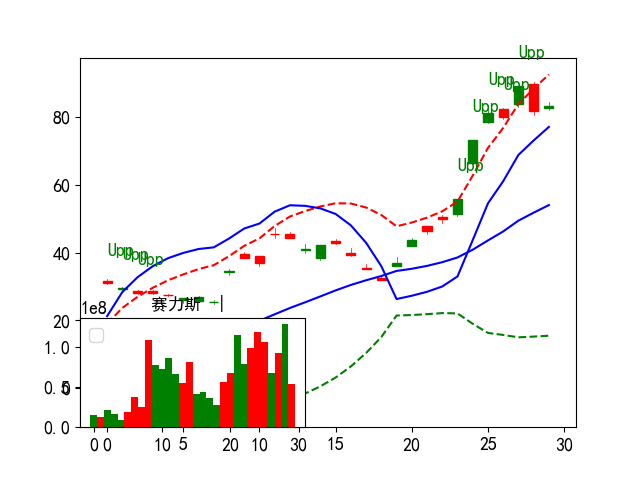

000628 4.17
lastb:0.0 xratio:0.82 ra_diff:4.17


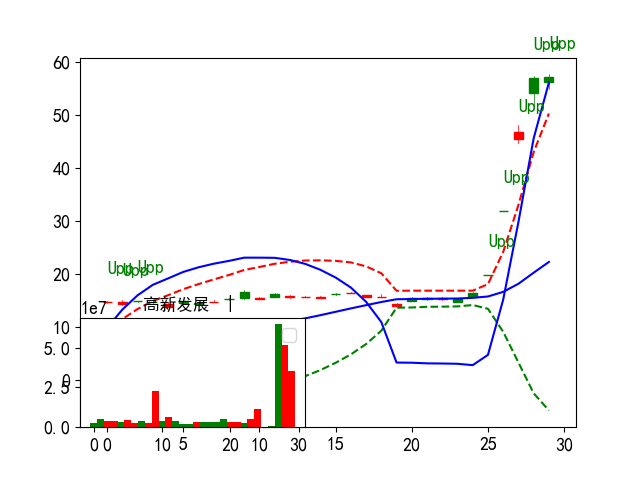

603283 2.33
lastb:0.0 xratio:0.35 ra_diff:2.33


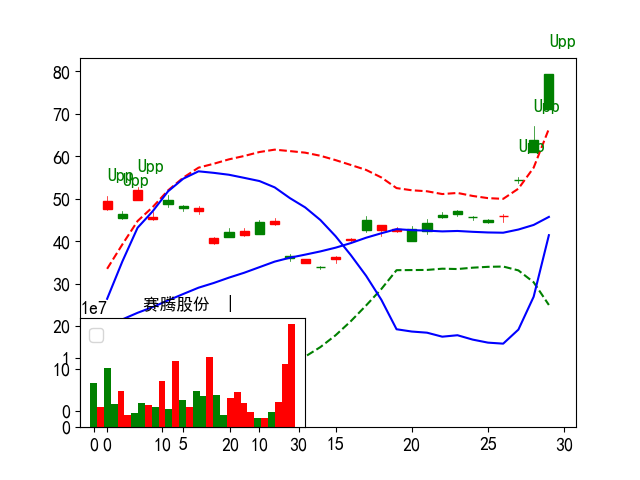

603496 3.64
lastb:0.0 xratio:0.79 ra_diff:3.64


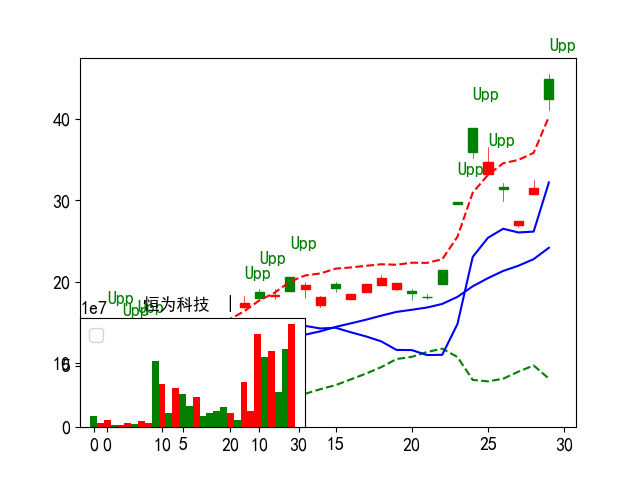

603178 4.2
lastb:0.0 xratio:0.79 ra_diff:4.2


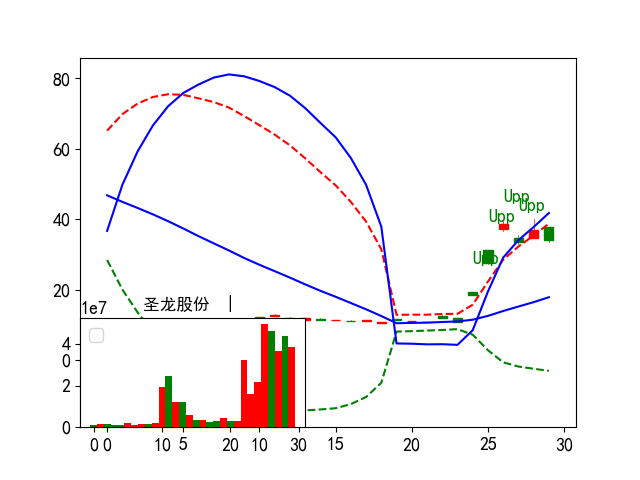

300928 1.93
lastb:0.0 xratio:0.88 ra_diff:1.93


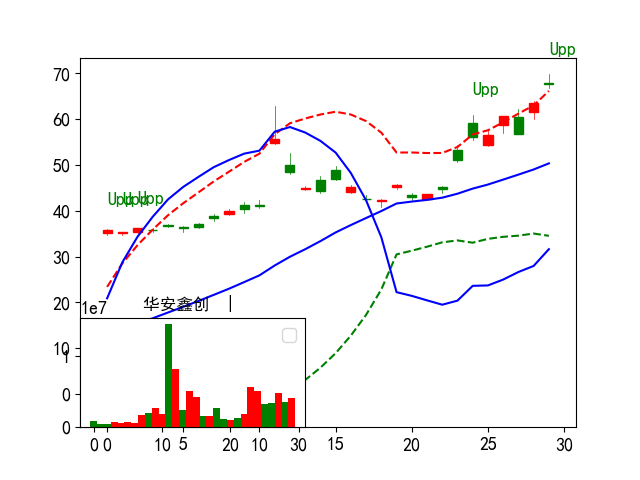

300765 3.45
lastb:0.0 xratio:0.59 ra_diff:3.45


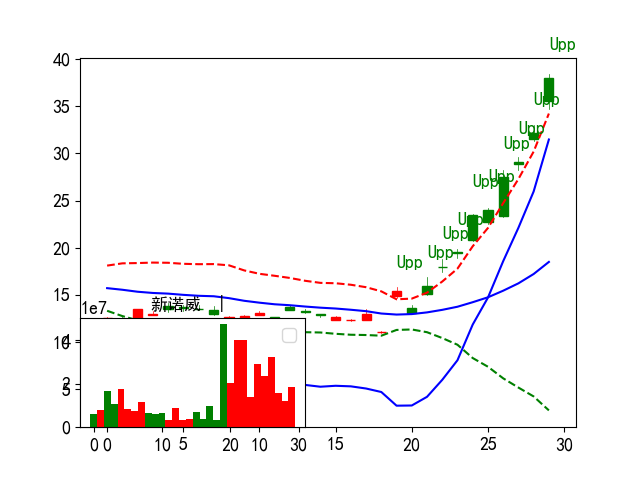

600520 3.04
lastb:0.0 xratio:0.4 ra_diff:3.04


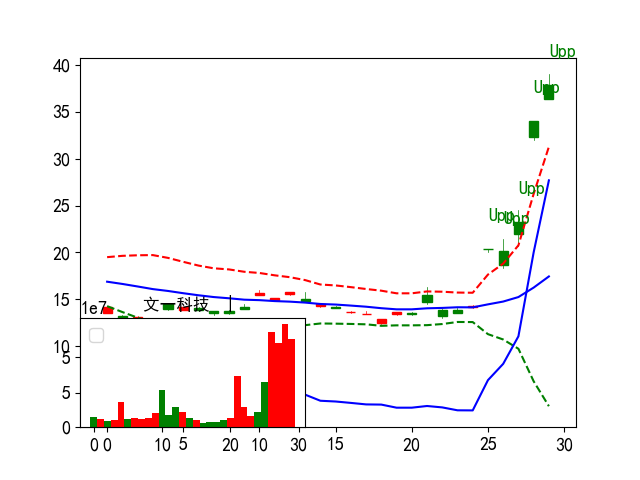

603985 2.27
lastb:0.0 xratio:0.73 ra_diff:2.27


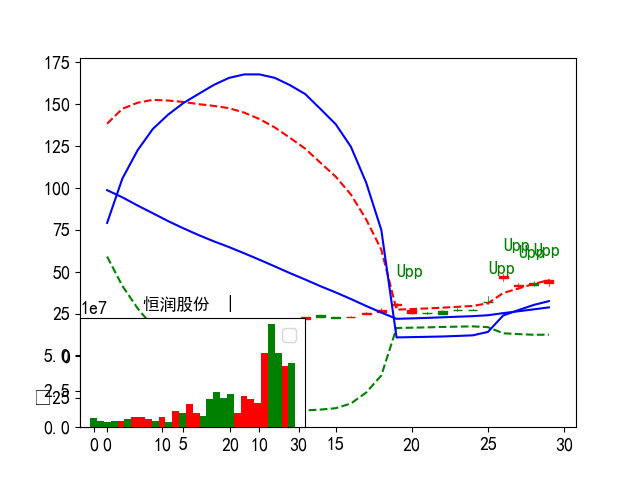

603266 2.76
lastb:0.0 xratio:0.46 ra_diff:2.76


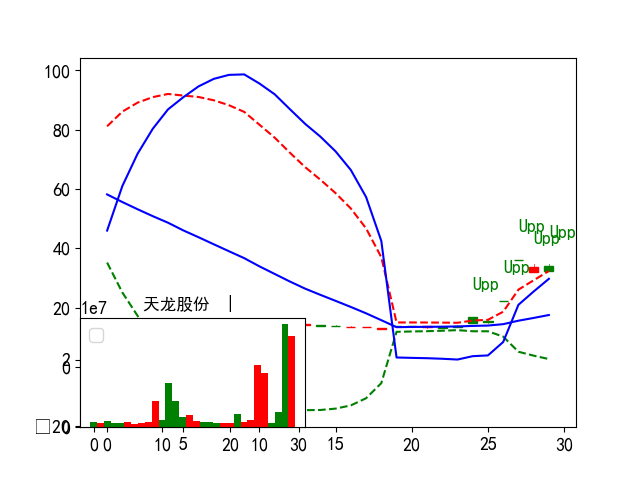

In [73]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [74]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date  lopen  lhigh   llow  close         vol        amount  \
code                                                                      
000628 2023-11-17  56.18  57.59  54.90   57.1  35493884.0  2.004855e+09   
603283 2023-11-17  71.22  79.30  71.22   79.3  14975932.0  1.153274e+09   

        ra_diff    ma5   ma10  ...  xratio    idx  couts  name   open   high  \
code                           ...                                             
000628     4.17  42.18  28.84  ...    1.20  41.69      5  高新发展  56.18  57.59   
603283     2.33  57.78  51.51  ...    0.84  36.40      3  赛腾股份  71.22  79.30   

          low  llastp            ticktime   perc  
code                                              
000628  54.90   56.60 2023-11-17 15:00:03   0.88  
603283  71.22   72.09 2023-11-17 15:00:01  10.00  

[2 rows x 39 columns]

(275, 39)

In [75]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

show_tdx_data(df_masklastd)
show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(361, 39)  lastd:(226, 39) 
Count:226 39


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
603178  圣龙股份      2 2023-10-27  10.01     4.12    0.60  25.99  29.13  37.90   
300364  中文在线      2 2023-11-17   2.54     2.29   -0.11  14.57  16.05  28.25   
600520  文一科技      3 2023-11-17   6.11     3.04    0.56  24.32  27.69  37.88   
300210  森远股份      4 2023-11-17   7.42     3.23    0.17   5.49   6.96   8.98   
603929  亚翔集成      3 2023-11-10  -2.85     2.16    0.29  14.96  15.50  25.24   
...      ...    ...        ...    ...      ...     ...    ...    ...    ...   
301019  宁波色母      1 2023-11-17   1.24     1.21    0.09   0.81   3.10  22.93   
002020  京新药业      1 2023-11-03  -0.57     1.30   -0.09   3.04   3.51  14.05   
600183  生益科技      1 2023-11-03   0.34     1.24    0.08   3.40   3.68  17.57   
300381   溢多利      1 2023-11-03   2.03     1.17    0.01   1.16   1.40   8.06   
300985  致远新能      3 2023-11-17   3.49     1.73    0.52  13.52  20.50  40.64   

        volsum5d  ...  perc1d   ma20   llow   vol1d   vol2d   vol3d   vol4d  \
code              ...                                                         
603178    1020.4  ...   18.68  13.97  36.60   -6.66  129.44   36.58  -50.86   
300364     430.5  ...   11.22  16.12  27.06  -32.36   48.98  404.79   18.56   
600520     309.2  ...   11.38  17.43  36.33  -15.03   22.29  -11.51  109.72   
300210     527.0  ...   14.39   4.16   8.21  -18.61  -23.94   74.88  102.38   
603929     913.6  ...   20.23  17.73  27.21  -33.72  871.35  -36.44  -68.68   
...          ...  ...     ...    ...    ...     ...     ...     ...     ...   
301019     101.1  ...    0.70  21.37  22.58  -38.62   73.98  -45.57  150.46   
002020     189.1  ...   10.37  12.19  13.86  125.08   47.75  -55.72  105.82   
600183     272.8  ...    1.98  15.49  17.15  -55.96  209.02  -75.33  158.48   
300381     426.7  ...    0.76   7.26   7.96  -38.72   -1.25  -47.33  527.97   
300985     112.5  ...    8.95  29.78  39.05   74.19  -38.77  -65.70   32.81   

         vol5d  perc3d  perc5d  
code                            
603178  911.87  208.13  240.92  
300364   -9.50  123.67  104.71  
600520  203.78   88.46  167.33  
300210  392.28   88.26  149.44  
603929  181.11   88.14   81.22  
...        ...     ...     ...  
301019  -39.18    4.89    8.01  
002020  -33.81    4.15   18.97  
600183   36.54    3.37   14.03  
300381  -13.96    1.91    9.75  
300985  109.94   -0.88   42.60  

[226 rows x 22 columns]

Count:10 39


name  couts       date  perc  ra_diff  xratio    idx    hat  close  \
code                                                                         
300893  松原股份      1 2023-10-27  3.68     1.36    0.12   6.66   8.48  30.15   
300663  科蓝软件      1 2023-11-17 -0.49     1.22    0.05   1.29   3.41  16.19   
600200  江苏吴中      3 2023-11-17 -0.42     1.33    0.07   2.17   2.88   9.38   
603167  渤海轮渡      1 2023-11-17  0.13     1.18    0.03   0.91   1.24   7.91   
000338  潍柴动力      2 2023-11-17  1.46     1.32    0.09   2.78   3.65  14.58   
301019  宁波色母      1 2023-11-17  1.24     1.21    0.09   0.81   3.10  22.93   
002020  京新药业      1 2023-11-03 -0.57     1.30   -0.09   3.04   3.51  14.05   
600183  生益科技      1 2023-11-03  0.34     1.24    0.08   3.40   3.68  17.57   
300381   溢多利      1 2023-11-03  2.03     1.17    0.01   1.16   1.40   8.06   
300985  致远新能      3 2023-11-17  3.49     1.73    0.52  13.52  20.50  40.64   

        volsum5d  ...  perc1d   ma20   llow   vol1d   vol2d  vol3d    vol4d  \
code              ...                                                         
300893      67.0  ...    8.57  24.55  28.60   47.87    9.17 -55.87   -41.16   
300663     321.0  ...    2.21  14.44  16.01   -0.74   37.66 -57.62   -31.21   
600200     176.2  ...   -0.64   7.86   9.26  -38.78  -44.89  48.45   246.84   
603167    1235.9  ...    1.54   7.20   7.86  -42.21  -17.72 -79.42  1358.50   
000338     109.9  ...    2.82  12.56  14.32   26.97  -14.05 -48.95    74.12   
301019     101.1  ...    0.70  21.37  22.58  -38.62   73.98 -45.57   150.46   
002020     189.1  ...   10.37  12.19  13.86  125.08   47.75 -55.72   105.82   
600183     272.8  ...    1.98  15.49  17.15  -55.96  209.02 -75.33   158.48   
300381     426.7  ...    0.76   7.26   7.96  -38.72   -1.25 -47.33   527.97   
300985     112.5  ...    8.95  29.78  39.05   74.19  -38.77 -65.70    32.81   

         vol5d  perc3d  perc5d  
code                            
300893  106.97    5.10   18.86  
300663  372.96    5.06   13.30  
600200  -35.46    5.04   19.19  
603167   16.78    4.91   13.32  
000338   71.82    4.89   15.81  
301019  -39.18    4.89    8.01  
002020  -33.81    4.15   18.97  
600183   36.54    3.37   14.03  
300381  -13.96    1.91    9.75  
300985  109.94   -0.88   42.60  

[10 rows x 22 columns]

### df_mask_hmax 061

df_mask_hmax:344
000628 4.17
lastb:0.0 xratio:0.82 ra_diff:4.17


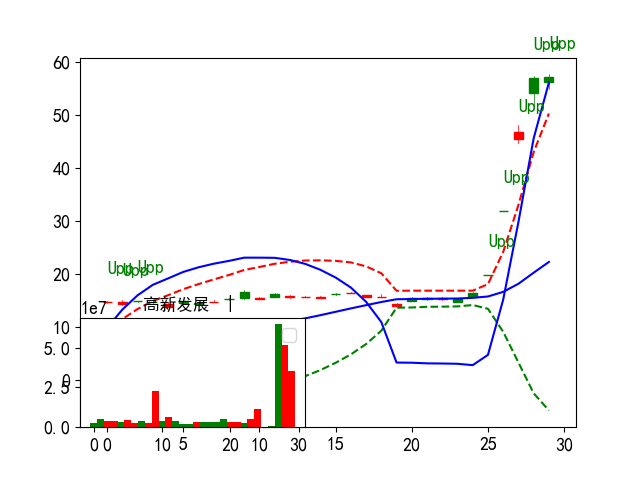

603991 1.7
lastb:0.0 xratio:0.12 ra_diff:1.7


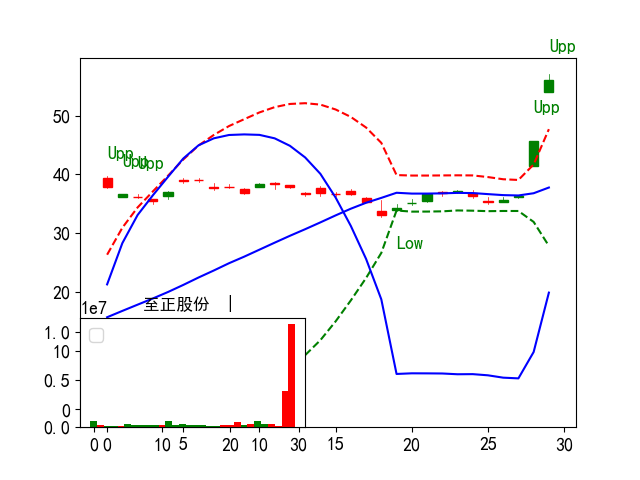

300180 1.59
lastb:0.0 xratio:0.03 ra_diff:1.59


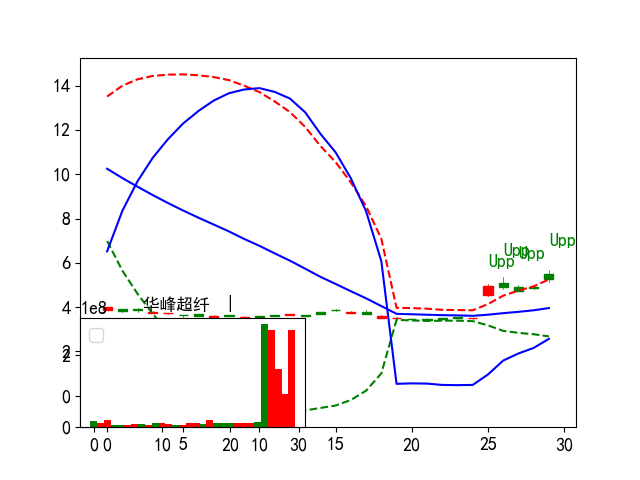

000056 1.77
lastb:0.0 xratio:-0.02 ra_diff:1.77


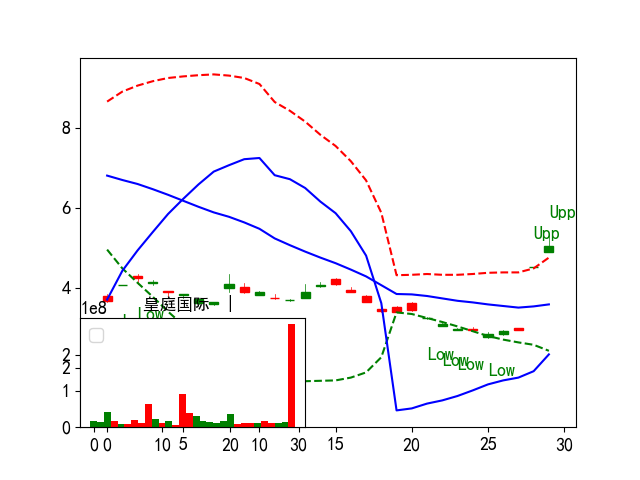

002729 1.42
lastb:0.0 xratio:0.04 ra_diff:1.42


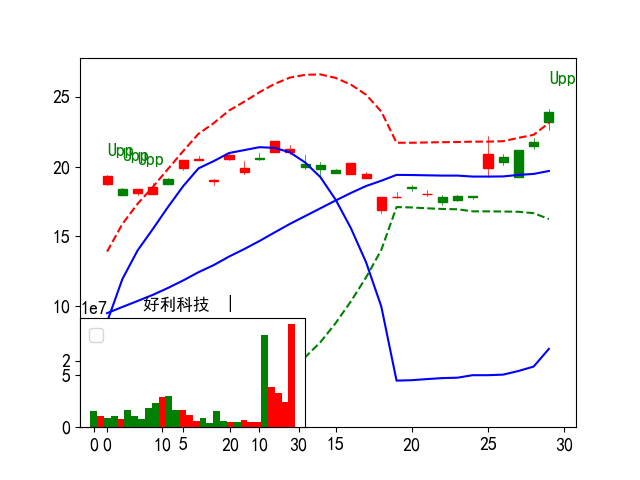

002657 1.51
lastb:0.0 xratio:0.04 ra_diff:1.51


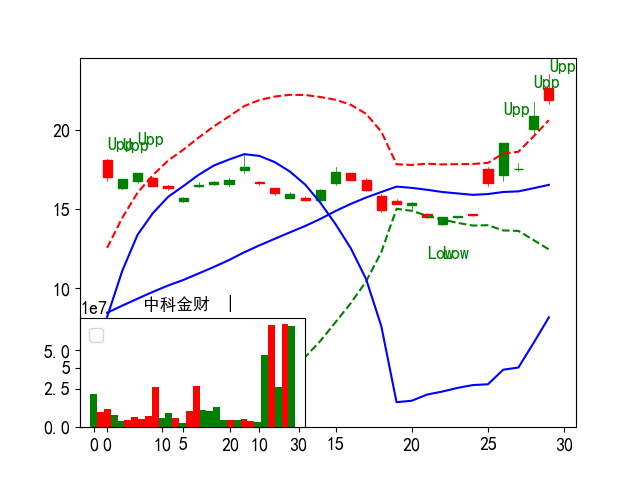

000632 1.23
lastb:0.0 xratio:0.01 ra_diff:1.23


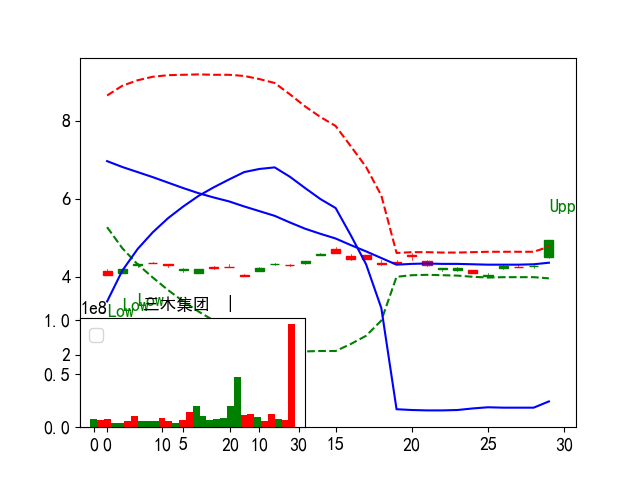

600775 1.9
lastb:0.0 xratio:-0.01 ra_diff:1.9


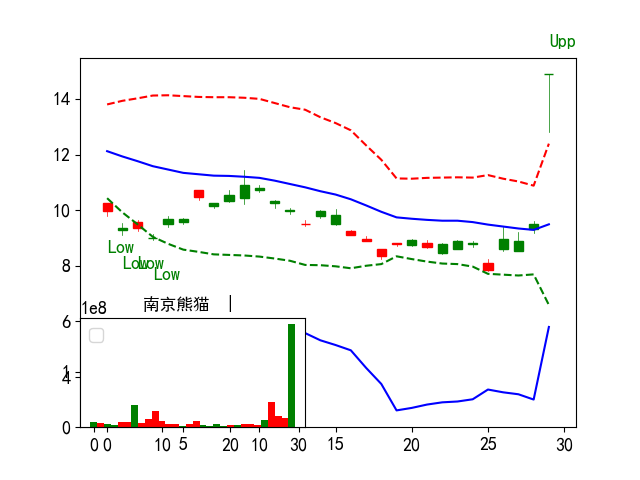

300554 2.06
lastb:0.0 xratio:0.15 ra_diff:2.06


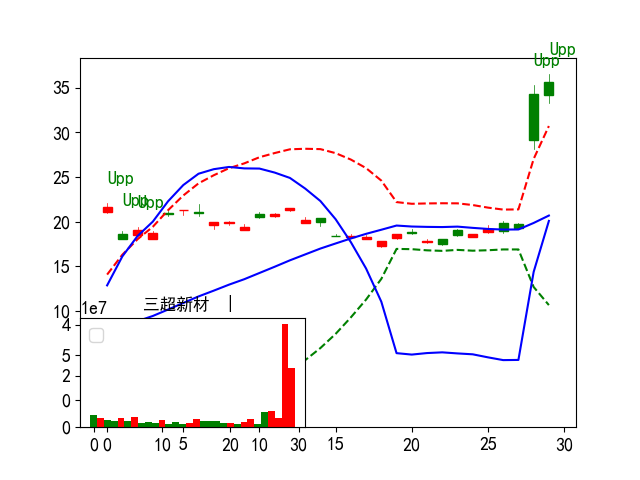

003019 1.33
lastb:0.0 xratio:0.04 ra_diff:1.33


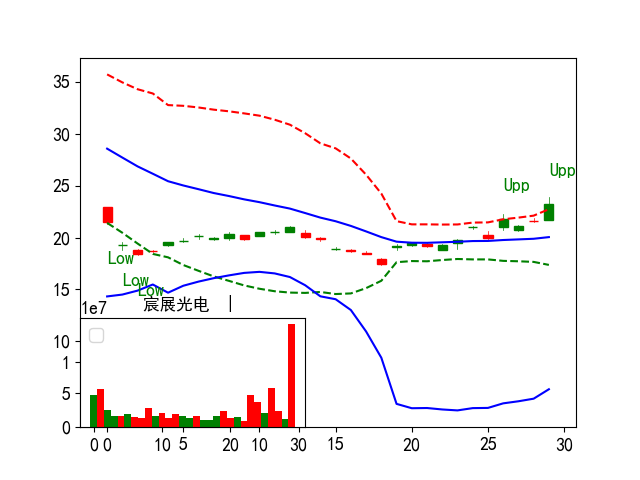

In [76]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:226
603178 4.2
lastb:0.0 xratio:0.79 ra_diff:4.2


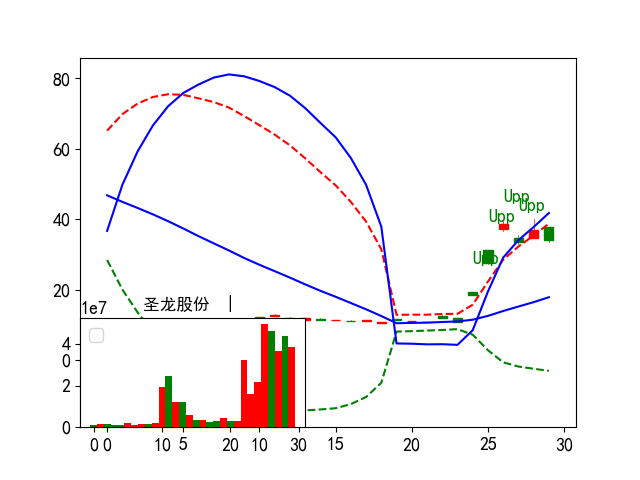

300364 2.29
lastb:0.0 xratio:-0.19 ra_diff:2.29


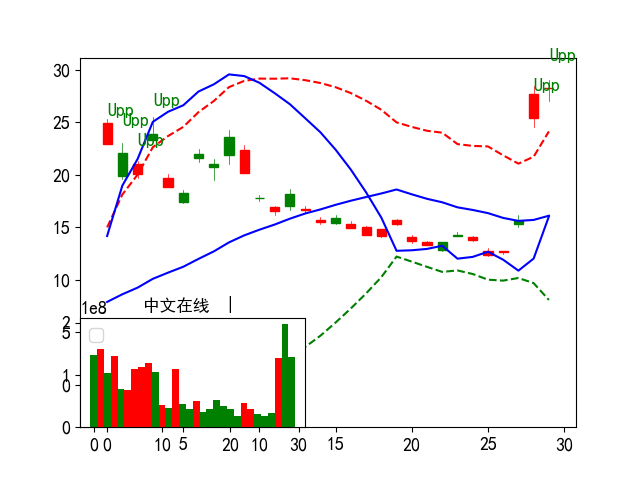

600520 3.04
lastb:0.0 xratio:0.4 ra_diff:3.04


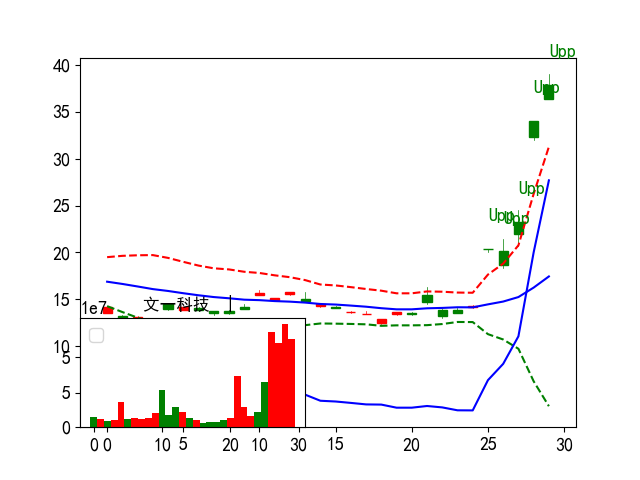

300210 3.23
lastb:0.0 xratio:0.12 ra_diff:3.23


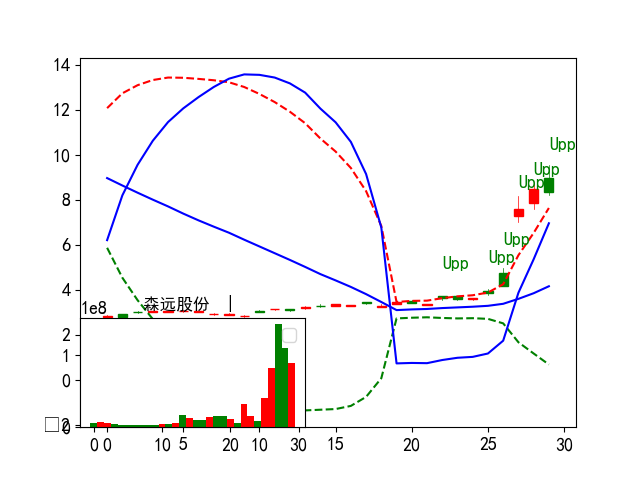

603929 1.75
lastb:0.0 xratio:0.25 ra_diff:1.75


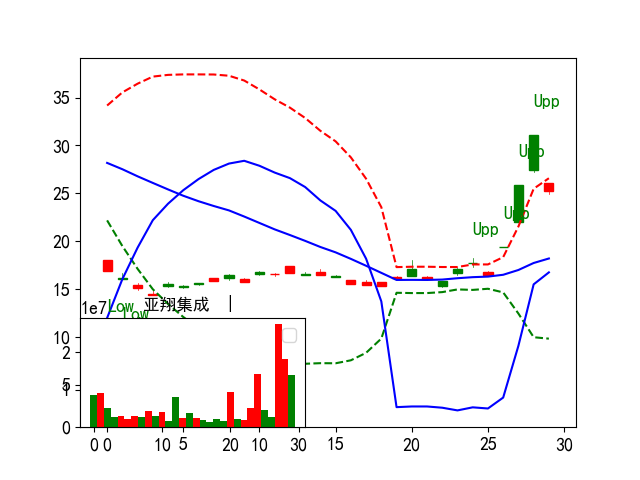

300554 2.06
lastb:0.0 xratio:0.15 ra_diff:2.06


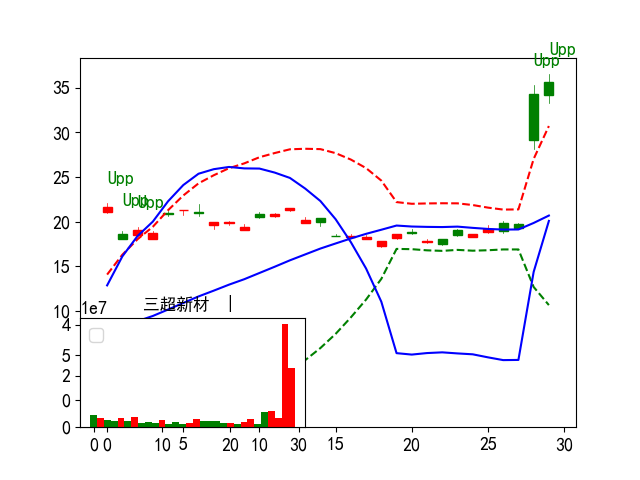

000628 4.17
lastb:0.0 xratio:0.82 ra_diff:4.17


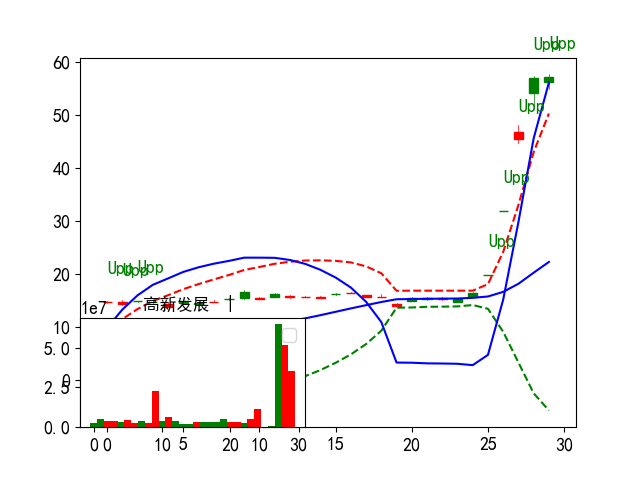

000056 1.77
lastb:0.0 xratio:-0.02 ra_diff:1.77


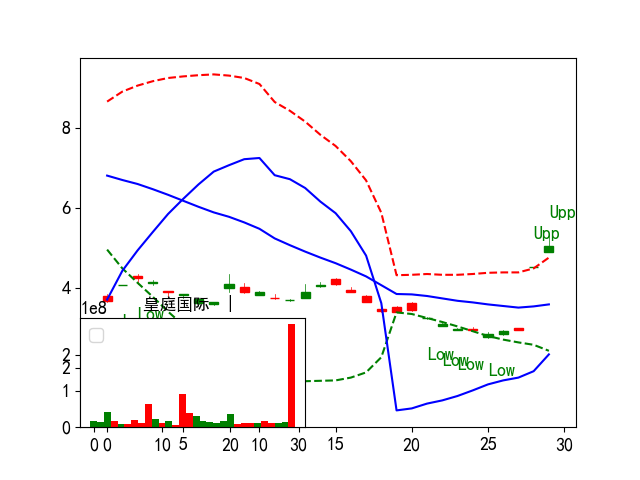

300063 1.9
lastb:0.0 xratio:0.02 ra_diff:1.9


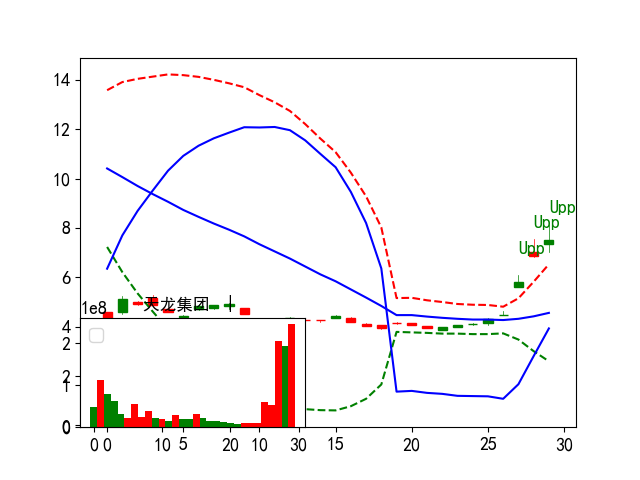

300709 1.8
lastb:0.0 xratio:0.11 ra_diff:1.8


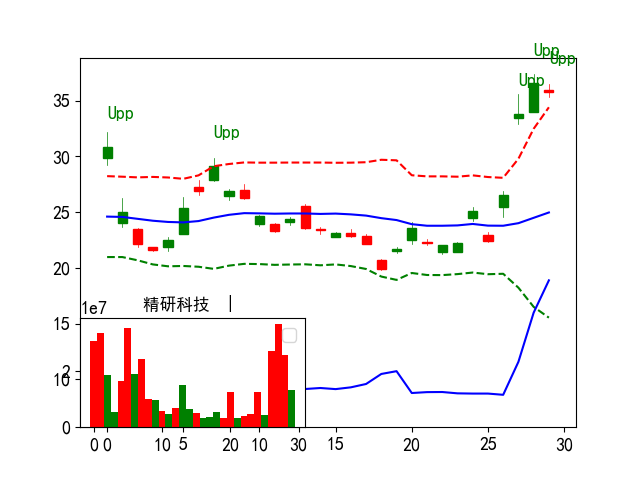

In [77]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [78]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250])

cross_hamx:115
Count:115 39


name  couts       date  perc  ra_diff  xratio    idx    hat  close  \
code                                                                         
300364  中文在线      2 2023-11-17  2.54     2.29   -0.11  14.57  16.05  28.25   
600520  文一科技      3 2023-11-17  6.11     3.04    0.56  24.32  27.69  37.88   
300210  森远股份      4 2023-11-17  7.42     3.23    0.17   5.49   6.96   8.98   
300554  三超新材      1 2023-11-17  0.71     2.06    0.23  16.78  20.08  35.61   
000628  高新发展      5 2023-11-17  0.88     4.17    1.20  41.69  56.04  57.10   
...      ...    ...        ...   ...      ...     ...    ...    ...    ...   
300786  国林科技      2 2023-11-17 -1.47     1.39    0.07   4.45   6.52  21.43   
300695  兆丰股份      3 2023-11-17  3.09     1.23    0.25   6.58   8.61  54.02   
300893  松原股份      1 2023-10-27  3.68     1.36    0.12   6.66   8.48  30.15   
300663  科蓝软件      1 2023-11-17 -0.49     1.22    0.05   1.29   3.41  16.19   
301019  宁波色母      1 2023-11-17  1.24     1.21    0.09   0.81   3.10  22.93   

        volsum5d  ...  perc1d   ma20   llow  vol1d    vol2d    vol3d   vol4d  \
code              ...                                                          
300364     430.5  ...   11.22  16.12  27.06 -32.36    48.98   404.79   18.56   
600520     309.2  ...   11.38  17.43  36.33 -15.03    22.29   -11.51  109.72   
300210     527.0  ...   14.39   4.16   8.21 -18.61   -23.94    74.88  102.38   
300554    1274.0  ...    3.67  20.68  33.33 -43.03  1047.40   -44.07    8.57   
000628    6653.6  ...    0.37  22.19  54.90 -31.51   -20.26  6589.00  213.64   
...          ...  ...     ...    ...    ...    ...      ...      ...     ...   
300786     210.7  ...    5.57  17.63  20.80  14.50    75.00   -69.32  219.02   
300695     108.8  ...    4.79  48.37  52.12  58.23   -16.62   -55.64  149.64   
300893      67.0  ...    8.57  24.55  28.60  47.87     9.17   -55.87  -41.16   
300663     321.0  ...    2.21  14.44  16.01  -0.74    37.66   -57.62  -31.21   
301019     101.1  ...    0.70  21.37  22.58 -38.62    73.98   -45.57  150.46   

         vol5d  perc3d  perc5d  
code                            
300364   -9.50  123.67  104.71  
600520  203.78   88.46  167.33  
300210  392.28   88.26  149.44  
300554  305.10   79.67   95.12  
000628  -97.30   79.45  249.66  
...        ...     ...     ...  
300786  -28.52    5.77   23.66  
300695  -26.82    5.28   10.61  
300893  106.97    5.10   18.86  
300663  372.96    5.06   13.30  
301019  -39.18    4.89    8.01  

[115 rows x 22 columns]

df_mask250:115
600025 1.19
lastb:0.0 xratio:0.03 ra_diff:1.19


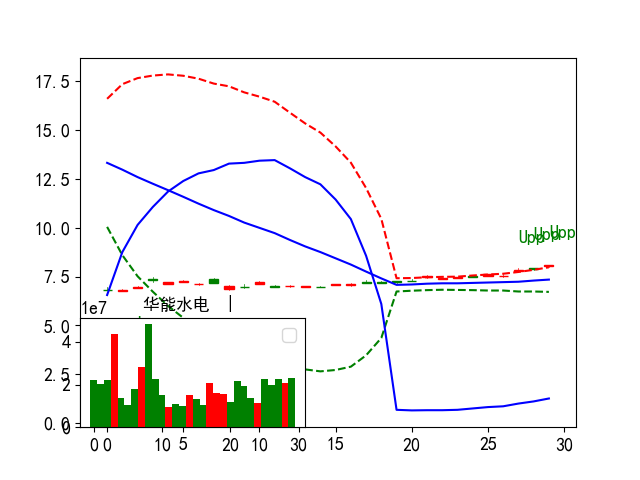

603201 1.26
lastb:0.0 xratio:0.11 ra_diff:1.26


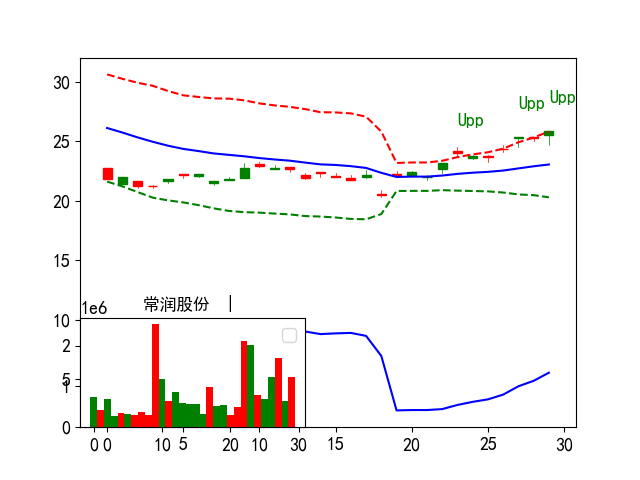

003019 1.33
lastb:0.0 xratio:0.04 ra_diff:1.33


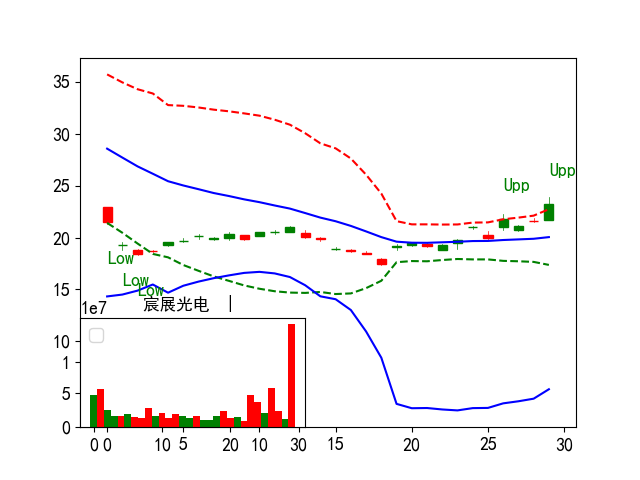

002722 1.18
lastb:0.0 xratio:0.03 ra_diff:1.18


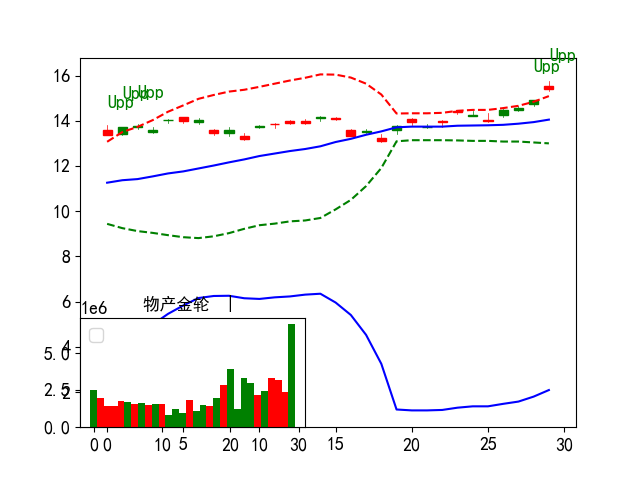

300318 1.27
lastb:0.0 xratio:0.01 ra_diff:1.27


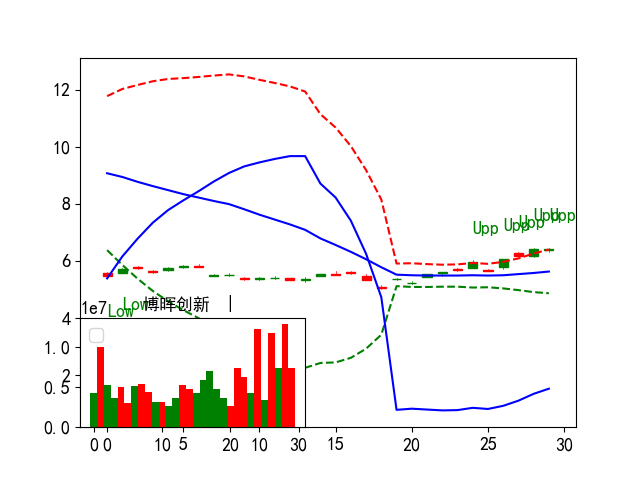

300786 1.39
lastb:0.0 xratio:0.02 ra_diff:1.39


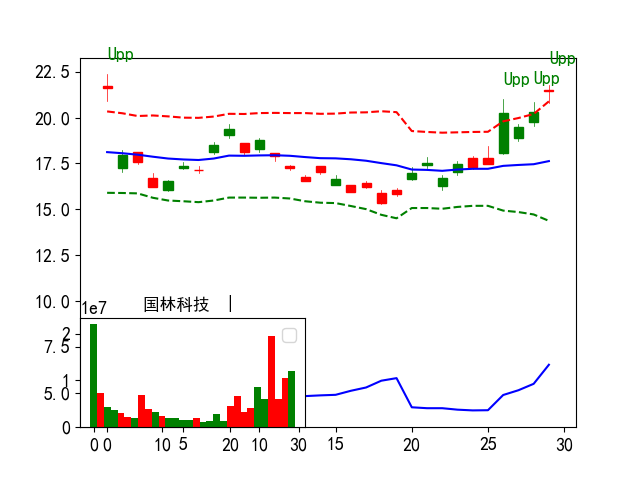

300695 1.23
lastb:0.0 xratio:0.24 ra_diff:1.23


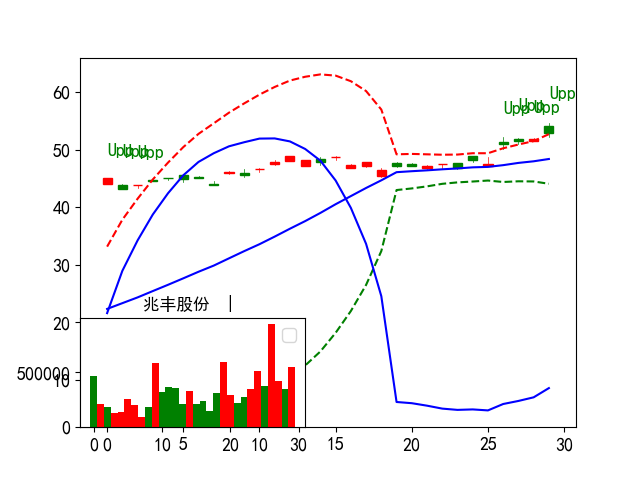

300893 1.42
lastb:0.0 xratio:0.2 ra_diff:1.42


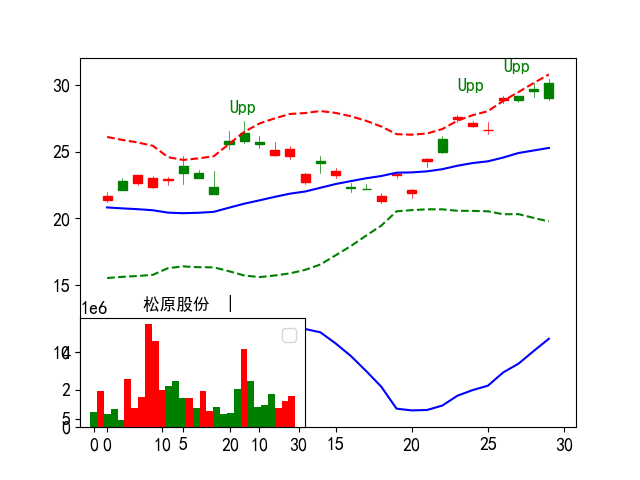

300663 1.22
lastb:0.0 xratio:0.04 ra_diff:1.22


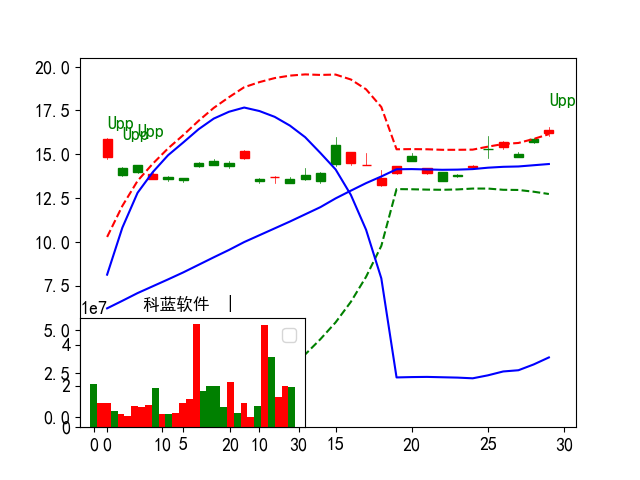

301019 1.21
lastb:0.0 xratio:0.1 ra_diff:1.21


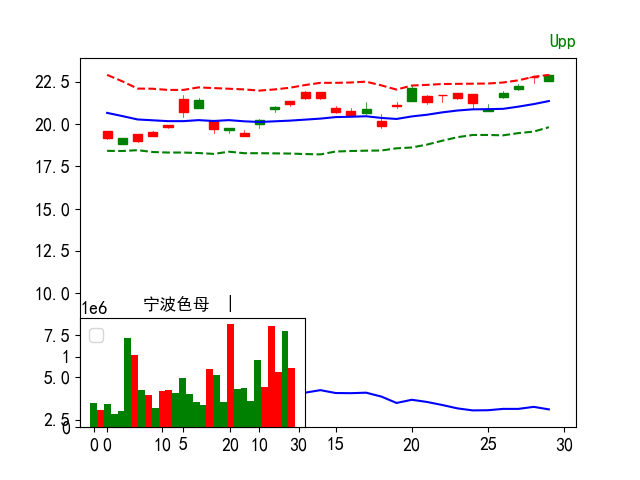

In [79]:
print("df_mask250:%s"%(len(cross_hmax_250)))
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 写入061

In [80]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [81]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [82]:
top_temp.shape
top_temp.index

(77, 33)

Index(['300765', '300210', '600520', '601127', '603985', '603266', '603353',
       '603629', '301236', '603178', '301015', '603009', '300735', '002827',
       '300429', '000628', '002771', '002456', '002947', '300180', '300290',
       '603929', '300063', '300985', '603220', '300798', '300606', '300375',
       '300337', '002657', '002981', '002786', '002682', '002387', '000676',
       '300709', '603108', '603729', '603037', '603003', '301128', '605086',
       '600792', '601901', '603283', '603516', '603615', '603768', '603991',
       '000829', '600331', '605319', '002988', '300042', '002803', '002238',
       '002232', '000925', '605218', '600133', '603496', '300364', '300608',
       '301091', '300951', '300928', '300926', '300812', '300580', '301117',
       '300554', '300446', '300391', '301297', '300291', '300135', '002584'],
      dtype='object', name='code')

## plt.close('all')

In [83]:
# plt.close('all')

# 写入060